This code should do the following:<br>
XXX&nbsp;  1) Take an input temperature and spew back a model spectrum<br>
XXX&nbsp; 2) Take two spectra and compute relevant flux contribution from each, given a filter profile<br>
XXX&nbsp;     3) Compute the adjusted transit depth assuming unocculted spots with the properties above<br>
XXX&nbsp;     4) Take a model transmission spectrum, adjust it according to two parameters:<br>
XXX&nbsp; &nbsp;         Spot Teff (converted to contrast using 1-3)<br>
 &nbsp; &nbsp;        Spot coverage<br>
XXX&nbsp;     5) Compare that model transmission spectrum to observed data inside emcee. <br>
&nbsp;     6) Make work with non-symmetric errors

Additional component (Jan 30):
nbsp; In the first iteration, I locked the warm region of the star to a fixed temperature. This is only true if fS is small. What I should do is force it to a value the resulting optical spectrum yields the correct answer (since that is how we measure Teff). This is a small effect, because the optical is dominated by the warm region (Wein tail is steep), but it's not too hard to fix so let's just add it in. 
  

In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.timeseries import LombScargle
import astropy.units as u
import healpy as hp
from lightkurve import search_lightcurvefile
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter
from multiprocessing import Pool
from scipy import stats
import numpy.random as random
from scipy import optimize
import emcee
import corner
import random
from gaussfold import gaussfold as gf

import multiprocessing as mp
Pool = mp.get_context('fork').Pool

In [2]:
## make the plots not suck
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9

In [3]:
import multiprocessing
import os
from multiprocessing import Pool
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import cpu_count

In [4]:
def to_str(var):
    if type(var) is list:
        return str(var)[1:-1] # list
    if type(var) is np.ndarray:
        try:
            return str(list(var[0]))[1:-1] # numpy 1D array
        except TypeError:
            return str(list(var))[1:-1] # numpy sequence
    return str(var) # everything else

In [5]:
## parameters we adjust

num = 2

In [6]:
modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits' ## these models go a bit cooler. 
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data
teff = np.squeeze(data['teff'])
logg = np.squeeze(data['logg'])
afe = np.squeeze(data['a_fe'])
mh = np.squeeze(data['metal'])
spectra = np.squeeze(data['spectrum'])
loc = np.where((logg == 4.5) & (mh == 0) & (teff > 1000) & (afe == 0))
modelteff = teff[loc]
modelspectra = np.squeeze(spectra[:,loc])
lambda0 = 1000
nlambda = 149501
dlambda = 2
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)

Filename: /Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 44252296E, 296E, 296E, 296E, 296E, 296E]   


In [7]:
ll = np.where((modelwave > 3400) & (modelwave < 53000))
modelspectra = np.squeeze(modelspectra[ll,:])
modelwave = modelwave[ll]
lambda0 = 3000
nlambda = int((55000-3000)/5)
dlambda = 5
## resample model spectra
newlambda = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
for i in range(0,np.size(modelteff)):
    tmp = np.array(modelspectra[:,i])
    interpfunc1 = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
    modelspec_new = interpfunc1(newlambda)
    modelspec_new = gf(newlambda, modelspec_new, 10)
    newmodel[:,i] = modelspec_new

modelwave = newlambda
modelspectra = newmodel

print(np.shape(modelteff),np.shape(modelspectra),np.shape(modelwave))
print(np.max(modelteff),np.min(modelteff))

(29,) (10400, 29) (10400,)
3900.0 1100.0


In [8]:
# modelpath = '/Users/andrewmann/Dropbox/Radii/Models_K233_Feb2020.fits'
# hdul = fits.open(modelpath)
# hdul.info()
# hdr = hdul[1].header
# data = hdul[1].data
# lambda0 = 4000
# nlambda = 210001
# dlambda = 0.1
# modelwave2 = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
# modelteff2 = np.squeeze(data['teff'])
# modellogg2 = np.squeeze(data['logg'])
# modelafe = np.squeeze(data['a_fe'])
# modelmh2 = np.squeeze(data['metal'])
# modelspectra2 = np.squeeze(data['spectrum'])

# ll = np.where((modelwave2 > 3400) & (modelwave2 < 53000))
# modelspectra2 = np.array(np.squeeze(modelspectra2[ll,:]))
# modelwave2 = modelwave2[ll]
# lambda0 = 3000
# dlambda = 2
# nlambda = int((55000-3000)/dlambda)
# newlambda2 = np.array(np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda))
# newmodel2 = np.array(np.zeros((np.size(newlambda2),np.size(modelteff2))))
# for i in range(0,np.size(modelteff2)):
#     tmp = np.array(modelspectra2[:,i])
#     interpfunc2 = interpolate.interp1d(modelwave2, tmp, kind='cubic',fill_value="extrapolate")
#     modelspec_new2 = interpfunc2(newlambda2)
#     modelspec_new2 = gf(newlambda2, modelspec_new2, 8)
#     newmodel2[:,i] = modelspec_new2

# modelwave2 = np.array(newlambda2)
# modelspectra2 = np.array(newmodel2)

In [9]:
# print(np.shape(modelwave2),np.shape(modelspectra2),np.shape(modelteff2))
# print(modelteff2)
# spec1 = getspec(modelteff2,modelspectra2,3540)
# spec2 = getspec(modelteff2,modelspectra2,3200)
# plt.plot(modelwave2,spec1)
# plt.plot(modelwave2,spec2)
# plt.xlim(5000,10000)
# plt.ylim(1e4,1e6)
# plt.show()

In [10]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    #print(loc,teffs[loc])
    #if np.size(loc) < 1:
    ## interpolate
    #above = np.min(np.where((logg == 4.5) & (afe == 0) & (mh == 0) & (teff > inteff)))
    #below = np.max(np.where((logg == 4.5) & (afe == 0) & (mh == 0) & (teff < inteff)))
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

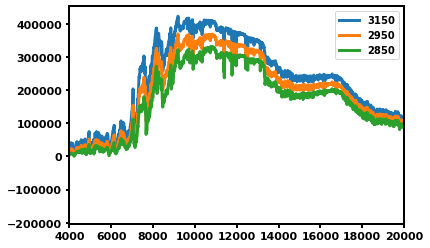

In [11]:
spec1 = getspec(modelteff,modelspectra,3050)
spec2 = getspec(modelteff,modelspectra,2950)
spec3 = getspec(modelteff,modelspectra,2850)
plt.plot(modelwave,spec1,label='3150')
plt.plot(modelwave,spec2,label='2950')
plt.plot(modelwave,spec3,label='2850')
plt.xlim(4000,20000)
plt.legend()
plt.show()

# spec4 = getspec(modelteff2,modelspectra2,3000)
# spec5 = getspec(modelteff2,modelspectra2,2950)
# spec6 = getspec(modelteff2,modelspectra2,2900)
# plt.plot(modelwave2,spec4,label='3000-2',alpha=0.5)
# plt.plot(modelwave2,spec5,label='2950-2',alpha=0.5)
# plt.plot(modelwave2,spec6,label='2900-2',alpha=0.5)
# plt.xlim(6000,8000)
# plt.ylim(1e4,0.3e6)
# plt.legend()
# plt.show()

# plt.plot(modelwave2,spec2-spec5)
# plt.xlim(6000,8000)
# plt.ylim(-1e5,1e5)
# plt.show()

In [12]:
from scipy import interpolate

def convolve_filter(w,s,fw,ft):
    interpfunc = interpolate.interp1d(w, s, kind='linear')
    interpolflux = interpfunc(fw)
    flux = np.sum(ft*interpolflux)
    return(flux)

HST2
dict_keys(['name', 'wl_min', 'wl_max'])


True

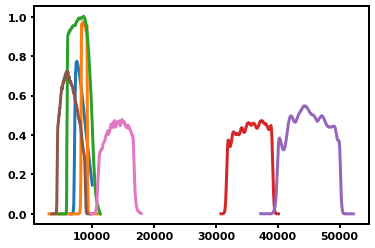

In [13]:
x,y = np.genfromtxt('filters/mearth.tsv', delimiter=';', unpack=True)
x*=10
plt.plot(x,y, label='MEarth')
mearth = TabulatedFilter('mearth', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/pstr-zs-avg.txt', unpack=True)
x*=10
plt.plot(x,y, label='zs')
zs = TabulatedFilter('zs', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/tess-response-function-v1.0.csv', unpack=True, comments='#', delimiter=',')
x*=10
plt.plot(x,y, label='tess')
tess = TabulatedFilter('tess', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch1trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=10000
plt.plot(x,y, label='Sp1')
s1 = TabulatedFilter('S1', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch2trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=10000
plt.plot(x,y, label='Sp2')
s2 = TabulatedFilter('S2', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/Kepler_Kepler.K.dat', unpack=True, comments='#', delimiter=',')
#x/=10
plt.plot(x,y, label='Kepler')
kepler = TabulatedFilter('Kepler', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/HST_WFC3_IR.G141.dat', unpack=True, comments='#', delimiter=' ')
#x/=10
plt.plot(x,y, label='G141')
G141 = TabulatedFilter('G141', x[np.isfinite(y)], y[np.isfinite(y)])

## HST bands
b1 = [11108,11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042]
b2 = [11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042,16432]
b1 = [11108,11773.5,12439,13104.5,13770,14435.5,15101,15766.5]
b2 = [11773.5,12439,13104.5,13770,14435.5,15101,15766.5,16432]
nbins = 8
tmp = np.linspace(10880,16800,nbins+1)
b1 = np.round(tmp[0:nbins])
b2 = np.round(tmp[1:nbins+1])
b1_num = np.array(b1)#/10
b2_num = np.array(b2)#/10
HST_bands = []
hst_names = np.array(b1,dtype=str)
for i in range(0,np.size(b1)):
    str1 = (to_str(round(b1[i])))
    str2 = (to_str(round(b2[i])))
    hst_names[i] = str(str1)+'--'+str(str2)         
counter = 1
for i,j in zip(b1_num,b2_num):
    HST_bands.append(BoxcarFilter('HST'+str(counter),i,j))
    counter=counter+1

    
#print(HST_bands)
filters = HST_bands
filters.append(mearth)
filters.append(kepler)
filters.append(s1)
filters.append(s2)
print(filters[1].name)
fnames = []
for i in range(0,np.size(filters)):
    fnames = np.append(fnames,filters[i].name)
## wl (double-u el) and tm
filters[10].__dict__.keys()
#filters[0].name
#names
#print(G141.tm)
inc = np.squeeze(np.where(fnames == 'HST1'))
print(filters[inc].__dict__.keys())
hasattr(filters[inc],'wl_max')

In [14]:
## given depth (D), spot fraction (fS), and two spectra, compute the adjusted transit depth
def depth_adjust(filt,D,fS,wav,surf,spot):
    star = surf*(1.-fS) + spot*fS
    outoftransit = star
    intransit = (surf-surf*(D/(1.-fS)))*(1.-fS) + spot*fS
    transit = (outoftransit-intransit)/outoftransit
    if hasattr(filt,'wl'):
        wl = filt.wl
        tm = filt.tm
    else:
        wl = np.arange(filt.wl_min,filt.wl_max,1)
        tm = wl*0+1.
    #plt.plot(wav,transit)
    #plt.xlim(np.min(wl),np.max(wl))
    #plt.ylim(D*0.99,D*1.2)
    #plt.show()
    outoftransit_flux = convolve_filter(wav,outoftransit,wl,tm)
    intransit_flux = convolve_filter(wav,intransit,wl,tm)
    #measured = convolve_filter(wav,transit,wl,tm)
    #outoftransit_flux = convolve_filter(wav,outoftransit,wl,tm)
    #intransit_flux = convolve_filter(wav,intransit,wl,tm)
    newD = (outoftransit_flux-intransit_flux)/outoftransit_flux
    return(newD)

In [15]:
star = getspec(modelteff,modelspectra,3540)
spot = getspec(modelteff,modelspectra,3200)

fSpot = 0.4
Depth = 0.0013
print(np.size(filters))
model_depths = []
for i in range(0,np.size(filters)):
    filt = filters[i]
    newD = depth_adjust(filt,Depth,fSpot,modelwave,star,spot)
    print(filt.name,newD)
    model_depths.append(newD)
# inc = np.squeeze(np.where(fnames == 'tess'))
# wl = filters[inc].wl
# tm = filters[inc].tm
# star2 = star*5
# t3 = convolve_filter(wave,spot,wl,tm)
# t2 = convolve_filter(wave,star,wl,tm)
# t1 = convolve_filter(wave,star2,wl,tm)
# print(t3,t2,t1)

# interpfunc1 = interpolate.interp1d(wave, star, kind='linear')
# interpfunc2 = interpolate.interp1d(wave, star2, kind='linear')
# match1 = interpfunc1(wl)
# match2 = interpfunc2(wl)
# plt.plot(wave,star)
# plt.plot(wl,match1)
# plt.plot(wl,match2)
# print(np.sum(tm*match1))
# print(np.sum(tm*match2))
# plt.xlim(5000,11000)
# plt.show()

12
HST1 0.0014607581057952846
HST2 0.0014513539659758254
HST3 0.001445212984206583
HST4 0.001463993224102809
HST5 0.0014866251765354255
HST6 0.0014878439702045894
HST7 0.0014801405852627283
HST8 0.0014631173721323912
mearth 0.0015597906313718803
Kepler 0.0016628369686456461
S1 0.0014248609410256934
S2 0.0013967814101501252


In [16]:
## read in some data
depth, errp, errm = np.loadtxt('bins_result_run46.dat',unpack=True,skiprows=1)

In [17]:
#define functions for MCMC
def ln_prior(theta):
    fS, Tspot, D = theta
    if fS < 0.0 or fS > 1 or Tspot < 1500 or Tspot > 3700 or D < 0 or D > 1:
        return -np.inf
    return 0

def ln_likelihood(theta, depth_obs, depth_errp, depth_errm, filters, star, modelteff,modelspectra, swave):
    fS, Tspot, D = theta
    spot = getspec(modelteff,modelspectra,Tspot)
    
    depth_model = []
    for filt in filters:
        newD = depth_adjust(filt,D,fS,swave,star,spot)
        depth_model.append(newD)
        
    ll = np.where(depth_obs > depth_model)
    depth_err = depth_errp
    depth_err[ll] = depth_errm[ll]
    s_squared = np.square(depth_err)
    p = (1. / np.sqrt(2 * np.pi * s_squared)) * np.exp(-np.square(depth_obs - depth_model) / (2 * s_squared)) 
    output = np.sum(np.log(p))
    return output


def ln_posterior(theta, depth_obs, depth_errp, depth_errm, filters, star, modelteff,modelspectra, swave):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, depth_obs, depth_errp, depth_errm, filters, star, modelteff,modelspectra, swave)
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

In [18]:
nwalkers, ndim = 16, 3
nthreads = 12
initial_guesses = [0.6, 2900, 0.001]
star = getspec(modelteff,modelspectra,3470)
print('if this is inf, we have a problem:')
print(ln_posterior(initial_guesses,depth,errp,errm,filters,star,modelteff,modelspectra,modelwave))
pos0 = [initial_guesses*(1+0.01*np.random.randn(ndim)) for i in range(nwalkers)]

if this is inf, we have a problem:
76.48818697794691


In [ ]:
nsteps = 40000
burn =(nsteps//3)
thin = 1

#with Pool() as pool:
#sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(depth,err,filters,data,wave), pool=pool)
#sampler.run_mcmc(pos0, nsteps,progress=True)
filename = "Transspec"+str(num)+".h5"
backend = emcee.backends.HDFBackend(filename)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(depth,errp,errm,filters,star,modelteff,modelspectra,modelwave), backend=backend, threads=nthreads)
sampler.run_mcmc(pos0, nsteps,progress=True)

print('done')

 11%|█         | 4367/40000 [05:46<48:47, 12.17it/s]  

In [ ]:
flat = np.array(sampler.get_chain(discard=burn, thin=thin, flat=True))

flat_samples = np.array(flat)
#flat_samples[:,2]= np.log(flat_samples[:,2])
#flat_samples[:,1]= np.log10(flat_samples[:,1])
flat_samples[:,2]*=100
flat_samples[:,0]*=100
labels = [r'$f_{S}$ (%)',r'$T_{\rm{spot}}$ (K)','D (%)']
print(flat_samples.shape)
fig = corner.corner( 
    flat_samples, labels=labels,# show_titles=True,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},#title_fmt='.3f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Transspec_Cornerspots.pdf')

In [ ]:
#np.save('transspec'+str(num)+'_chain.npy', np.array(sampler.chain))
#np.save('transspec'+str(num)+'_prob.npy', np.array(sampler.lnprobability))
#np.save('transspec'+str(num)+'_accept.npy',np.array(sampler.acceptance_fraction))

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.show()
plt.savefig('Transspec_Walkers.pdf')

In [ ]:
from IPython.display import display, Math
labels = [r'f_{S}\ (\%)',r'T_{\rm{spot}}\ (K)','D (\%)']
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    if i == 1:
        txt = "\mathrm{{{3}}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
from scipy import integrate
## get out the wavelengths for each:
star = getspec(modelteff,modelspectra,3470)

leffs = []
for i in range(0,np.size(filters)):
    filt = filters[i]
    if hasattr(filt,'wl'):
        fw = filt.wl
        tm = filt.tm
    else:
        fw = np.arange(filt.wl_min,filt.wl_max,1)
        tm = fw*0+1.
    interpfunc = interpolate.interp1d(modelwave, star, kind='linear')
    interpolflux = interpfunc(fw)
    leff = np.sum(integrate.cumtrapz(fw*tm*interpolflux,fw))/np.sum(integrate.cumtrapz(tm*interpolflux,fw))
    print(filt.name,leff)
    leffs.append(leff)

In [ ]:
fS = np.percentile(flat_samples[:, 0],[50])/100.
Tspot = np.percentile(flat_samples[:, 1],[50])
D = np.percentile(flat_samples[:, 2],[50])/100.
spot = getspec(modelteff,modelspectra,Tspot)
surf = star
star = surf*(1.-fS) + spot*fS
outoftransit = star
intransit = (surf-surf*(D/(1.-fS)))*(1.-fS) + spot*fS
transit = (outoftransit-intransit)/outoftransit
print(fS,Tspot,D)

In [ ]:
## read in some data
depth, errp, errm = np.loadtxt('bins_result_run46.dat',unpack=True,skiprows=1)

In [ ]:
import matplotlib.ticker
fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)

leffs = np.array(leffs)
plt.errorbar(leffs/10000, depth, yerr=[errm,errp], fmt='o',label='Data')
plt.plot(modelwave/10000,transit,label='Spotted model',alpha=0.7)
plt.xscale('log')
plt.xticks([0.6, 0.9, 1.3, 2.0, 3.1, 4.6],labels=['0.6', '0.9', '1.1','2.0', '3.1', '4.6'])
plt.xticks([0.5, 1.1, 1.7, 2.3, 2.9, 3.5, 4.1, 4.7],labels=['0.5', '1.1', '1.7', '2.3', '2.9', '3.5', '4.1', '4.7'])
#locs, labels = plt.xticks() 
ax.set_ylabel(r'Transit Depth $(R_p/R_*)^2$')
ax.set_xlabel(r'Wavelength ($\mu m$)')
plt.legend()
ax.set_xlim(0.5,4.9)
ax.set_ylim(0.0008,0.0035)
plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.tight_layout()
#ax.set_aspect(200.0)
plt.savefig('Transspec_spots.pdf')

